# DATA

In [26]:
import pandas as pd
from sqlalchemy import create_engine

# TO BE packaged
db_connection_url = "postgresql://{}:{}@{}:{}".format(
    'postgres',
    'lHeJnnRINyWCzfkDOzKl',
    'database-gggi-1.cg4tog4qy0py.ap-northeast-2.rds.amazonaws.com',
    5432,
)

engine = create_engine(db_connection_url)


def select_metadata(engine=engine):
    sql = f'SELECT * FROM variablemetadata'
    with engine.connect() as conn:
        df = pd.read_sql(sql, conn)
    return df


def select_dataset(dataset_name='aquastat', engine=engine):
    sql = f'SELECT * FROM {dataset_name} INNER JOIN variablemetadata ON variablemetadata.\"Variable\"={dataset_name}.\"Variable\";'
    with engine.connect() as conn:
        df = pd.read_sql(sql, conn)
        df = df.loc[:,~df.columns.duplicated()]
    return df

aquastat = select_dataset('aquastat')
evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])

In [27]:
def select_dataset(dataset_name='aquastat', engine=engine):
    sql = f'SELECT * FROM {dataset_name} INNER JOIN meta{dataset_name} ON meta{dataset_name}.\"Variable\"={dataset_name}.\"Variable\";'
    with engine.connect() as conn:
        df = pd.read_sql(sql, conn)
        df = df.loc[:,~df.columns.duplicated()]
    return df

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()


In [28]:
def pivot(df):
    return df.pivot(index=['ISO', 'Year'], columns='Variable', values='Value')

In [29]:
aquastat.head()

,Area,Description,Year,Value,ISO,Variable,Unit,From
0,Afghanistan,Cultivated area (arable land + permanent crops),1992.0,8030.0,AFG,TC,1000 ha,AQUASTAT
1,Afghanistan,Cultivated area (arable land + permanent crops),1997.0,7790.0,AFG,TC,1000 ha,AQUASTAT
2,Afghanistan,Cultivated area (arable land + permanent crops),2002.0,7753.0,AFG,TC,1000 ha,AQUASTAT
3,Afghanistan,Cultivated area (arable land + permanent crops),2007.0,7910.0,AFG,TC,1000 ha,AQUASTAT
4,Afghanistan,Cultivated area (arable land + permanent crops),2012.0,7910.0,AFG,TC,1000 ha,AQUASTAT


In [30]:
aquastat = pivot(aquastat)\
          .groupby(level='ISO').fillna(method='ffill')\
          .groupby(level='ISO').fillna(method='bfill')


In [31]:
def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

In [32]:
X = df_to_dict(aquastat)

In [33]:
X['KC'] = cropcalendar.pivot(index=['ISO', 'Item'], columns='Variable', values='Value')['Kc']
X['ETa'] = pivot(evapotranspiration)['ETa'].groupby(level='ISO').fillna(method='ffill').fillna(method='bfill')
X['ETo'] = pivot(evapotranspiration)['ETo'].reset_index('Year', drop=True).dropna()
X['LWU'] = 0

# Model

In [34]:
from graphmodels.graphmodel_exp import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np

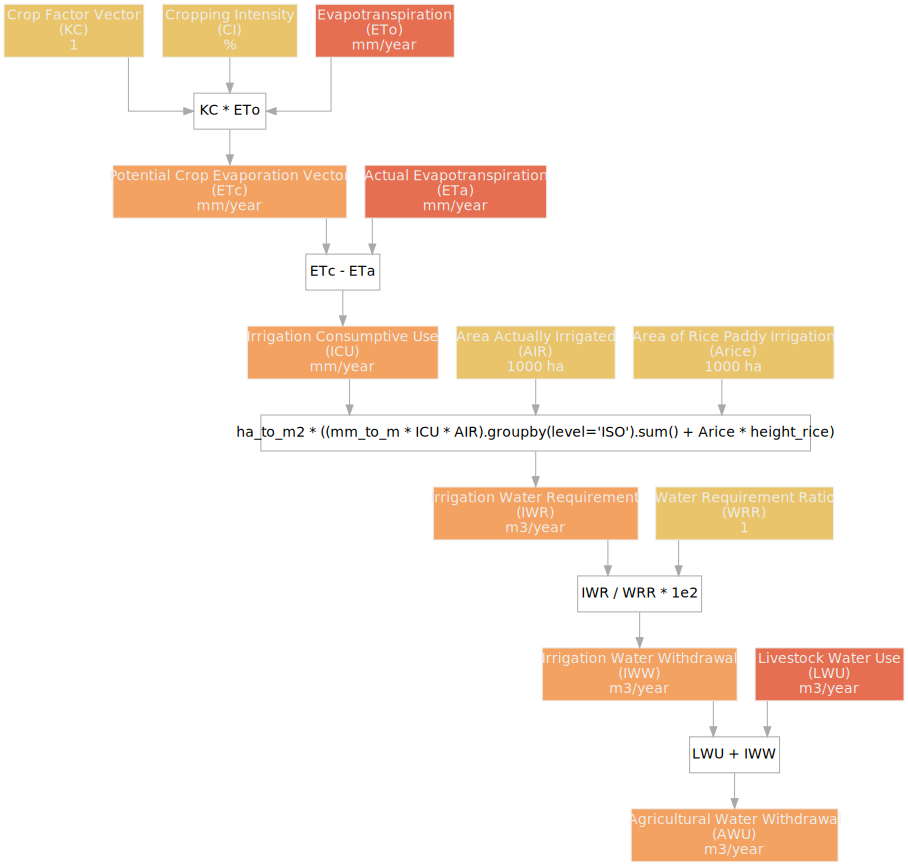

In [35]:
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e3 #* 1e3
mm_to_m = 1 # 1e-3

IWW_nodes = {'KC': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor Vector'},
             'CI': {'type': 'parameter', 'unit': '%', 'name': 'Cropping Intensity'},
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda KC, CI, ETo, **kwargs: KC * ETo
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: ETc - ETa
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
#              'PSIR': {'type': 'input',
#                       'unit': '1',
#                       'name': 'Proportion of Surface Irrigation'},
#              'PSPIR': {'type': 'input',
#                        'unit': '1',
#                        'name': 'Proportion of Sprinker Irrigation'},
#              'PLIR': {'type': 'input',
#                       'unit': '1',
#                       'name': 'Proportion of Localised Irrigation'},
#              'ESIR': {'type': 'parameter',
#                       'unit': '1',
#                       'name': 'Efficiency of Surface Irrigation'},
#              'ESPIR': {'type': 'parameter',
#                        'unit': '1',
#                        'name': 'Efficiency of Sprinker Irrigation'},
#              'ELIR': {'type': 'parameter',
#                       'unit': '1',
#                       'name': 'Efficiency of Localised Irrigation'},
#              'WRR_policy': {'type': 'variable',
#                             'name': 'Water Requirement Ratio',
#                             'unit': '1',
#                             'computation': lambda PSIR, ESIR, PSPIR, ESPIR, PLIR, ELIR, **kwargs: PSIR/ESIR + PSPIR / ESPIR + PLIR / ELIR
#                             },
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': 'm3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: ha_to_m2 * ((mm_to_m * ICU * AIR).groupby(level='ISO').sum() + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'LWU': {'type': 'input', 'name': 'Livestock Water Use', 'unit': 'm3/year'},
             'AWU': {'type': 'variable', 'unit': 'm3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda LWU, IWW, **kwargs: LWU + IWW
                     },
             }

IWW_model = GraphModel(IWW_nodes)

IWW_model.draw()

In [36]:
res = IWW_model.run(X)

In [ ]:
res['ETo'].loc['MEX', :, 2007]#.sum()

In [ ]:
res['AIR'].loc['HUN',2007] * 1e3

In [ ]:
res['ICU'].loc['HUN', :, 2007].sum()

In [37]:
res['IWW'].loc['HUN',]

Year
1990.0    3.895293e+08
1991.0    3.895293e+08
1992.0    3.895293e+08
1996.0    3.895293e+08
1997.0    3.895293e+08
2000.0    3.895293e+08
2002.0    3.895293e+08
2006.0    3.895293e+08
2007.0    3.895293e+08
2012.0    3.895293e+08
2016.0    3.895293e+08
2017.0    3.895293e+08
dtype: float64

In [ ]:
res['ICU'].loc['MEX', :, 2007].sum()

In [ ]:
X['ETo'].loc['MEX'] #* 1e9

In [ ]:
X['KC'].loc['MEX'] #* 1e9

In [ ]:
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': 'm3/year'},
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': 'm3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'TC': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Total Cultivated Land'},
             'Ai': {'type': 'variable',
                    'name': 'Proportion of Irrigated Land',
                    'unit': '',
                    'computation': lambda AIR, TC, **kwargs: AIR / TC
                    },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '',
                    'computation': lambda Ai, **kwargs: 1 / (1 + (Ai/(1-Ai)*0.375))
                    },
             'AGVA': {'type': 'parameter',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$'},

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},
 
             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
  
     
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, IGVA, SGVA, AGVA, **kwargs: (IGVA + SGVA + AGVA) / TWW
                     }}
EW1_model = GraphModel(EW1_nodes)

EW1_model.draw()


In [ ]:
ha_to_m2 = 1e4 
mm_to_m = 1e-3

EW2_nodes = {'P': {'type': 'input', 'unit': 'mm/year', 'name': 'Precipitation'},
             'ETa': {'type': 'input', 'unit': 'mm/year', 'name': 'Actual Evapotranspiration'},
             'A': {'type': 'input', 'unit': 'ha', 'name': 'Catchment Size'},
             'S': {'type': 'variable',
                   'name': 'Change in Surface Water Storage',
                   'unit': 'm3/year',
                   'computation': lambda P, ETa, A, **kwargs: (P - ETa) * A * ha_m2 * mm_to_m
                  },
             'SW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Surface Water'},
             'GW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Groundwater Water'},
             'Overlap': {'type': 'parameter',
                         'unit': 'm3/year',
                         'name': 'Overlap (Surface - Groundwater)'},
             'IRWR': {'type': 'variable',
                      'name': 'Internal Renewable Water Resources',
                      'unit': 'm3/year',
                      'computation': lambda GW, SW, S, Overlap, **kwargs: GW + (SW - S) - Overlap
                     },
             'ERWR': {'type': 'parameter',
                      'unit': 'm3/year',
                      'name': 'External Renewable Water Resources'},
             'TRF': {'type': 'variable',
                     'name': 'Total Renewable Freshwater',
                     'unit': 'm3/year',
                     'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
                    },
             'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
             'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
             'TNCW': {'type': 'variable',
                      'name': 'Total Non Conventional Water',
                      'unit': 'm3/year',
                      'computation': lambda DW, TW, **kwargs: DW + TW
                     },
             'TFA': {'type': 'variable',
                     'name': 'Total Freshwater Available',
                     'unit': 'm3/year',
                     'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
                    },
             'TWW': {'type': 'input', 'unit': 'm3/year', 'name': 'Total Water Withdrawal'},
             'EFR': {'type': 'parameter',
                     'unit': 'm3/year',
                     'name': 'Environmental Flow Requirement'},
             'EW2': {'type': 'output',
                     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                     'unit': '1',
                     'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR)
                    },
             'Natural EW2': {'type': 'output',
                             'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                             'unit': '1',
                             'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR)
                            }
            }

GraphModel(EW2_nodes).draw()


In [ ]:
#Municipal Water Use
MWU_nodes= [{'type': 'input',
  'name': 'Water Price', 
  'unit': '$/15m3',
  'id': 'P'},
  {'type': 'parameter',
  'name': 'GDP per capita',
  'unit': '$',
  'id': 'GDPC'}, 
  {'type': 'variable',
  'name': 'Municipal Water Demand',
  'unit': 'm3/year/person',
  'in': ['P','GDPC'],
  'computation': {'name': '2.39 * GDPC^0.37 * Price^-0.33 ', 'formula': lambda X: 2.39 * X['GDPC']**0.37 * X['P']**-0.33},
  'id': 'MWUD'},
  {'type': 'parameter',
  'name': 'Population',
  'unit': 'millions',
  'id': 'Pop'}, 
  {'type': 'variable',
  'name': 'Municipal Water Withdrawal',
  'unit': 'm3/year',
  'in': ['Pop','MWUD'],
  'computation': {'name': 'MWUD * Pop ', 'formula': lambda X: X['MWUD'] * X['Pop']},
  'id': 'MWU'},
    ]

GraphModel(MWU_nodes).draw()


In [ ]:
EW1_nodes =[ 
 #Industrial Water Use
{'type': 'parameter',  
  'name': 'Industrial Water Withdrawal',
  'unit': 'm3/year',
  'id': 'IWU'},
  {'type': 'parameter',
  'unit': 'ha (1000)',
  'name': 'Area Actually Irrigated',
  'id': 'AIR'},
  {'type': 'input',
  'name': 'Municipal Water Withdrawal',
  'unit': 'm3/year',
  'id': 'MWU'},    
{'type': 'input',
  'name': 'Agricultural Water Withdrawal',
  'unit': 'm3/year',
  'id': 'AWU'},

#Total Water Withdrawal
 {'type': 'variable',
  'name': 'Total Water Withdrawal',
  'unit': 'm3/year',
  'in': ['MWU','AWU', 'IWU'],
  'computation': {'name': 'AWU + IWU + MWU', 'formula': lambda X: X['AWU'] + X['IWU'] + X['MWU']},
  'id': 'TWW'},

 #Agricultural Water Use Efficiency
 {'type': 'parameter',
  'unit': 'ha (1000)',
  'name': 'Total Cultivated Land',
  'id': 'TC'},
 {'type': 'variable',
  'name': 'Proportion of Irrigated Land',
  'unit': '',
  'in': ['AIR', 'TC'],
  'computation': {'name': 'AIR/TC', 'formula': lambda X: X['AIR'] / X['TC']},
  'id': 'Ai'},
{'type': 'variable',
  'name': 'Corrective coefficient',
  'unit': '',
  'in': ['Ai'],
  'computation': {'name': '1/(1+(Ai/(1-Ai)*0.375)', 'formula': lambda X: 1/(1 + (X['Ai']/(1-X['Ai'])*0.375))},
  'id': 'Cr'},
{'type': 'parameter',
  'name': 'Agricultural Gross Value Added',
  'unit': '$',
  'id': 'AGVA'},
{'type': 'variable',
  'name': 'Agricultural Water Use Efficiency',
  'unit': '$/m3',
  'in': ['AGVA', 'Cr', "AWU"],
  'computation': {'name': 'AGVA * (1-Cr)/AWU', 'formula': lambda X: X['AGVA'] * (1-X['Cr'])/X['AWU']},
  'id': 'WUEa'},  

#Industrial Water Use Efficiency
{'type': 'parameter',
  'name': 'Industrial Gross Value Added',
  'unit': '$',
  'id': 'IGVA'},

{'type': 'variable', #won't calculate this variable, have to define a value in X directory for model to run
  'name': 'Industrial Water Use Efficiency',
  'unit': '$/m3',
  'in': ['IGVA','IWU'],
  'computation': {'name': 'IGVA/IWU', 'formula': lambda X: X['IGVA']/ X['IWU']},
  'id': 'WUEi'},

#Municipal/Service sector water use efficiency
  {'type': 'parameter',
  'name': 'Service Sector Gross Value Added',
  'unit': '$',
  'id': 'SGVA'},
{'type': 'variable',
  'name': 'Service Sector Water Use Efficiency',
  'unit': '$/m3',
  'in': ['SGVA','MWU'],
  'computation': {'name': 'SGVA/MWU', 'formula': lambda X: X['SGVA']/ X['MWU']},
  'id': 'WUEs'},

#EW1 calculation
{'type': 'variable',
  'name': 'Proportion of Agricultural Water Use',
  'unit': '',
  'in': ['AWU','TWW'],
  'computation': {'name': 'AWU/TWW', 'formula': lambda X: X['AWU'] / X['TWW']},
  'id': 'Pa'},  

  {'type': 'variable', 
  'name': 'Proportion of Industrial Water Use',
  'unit': '',
  'in': ['IWU','TWW'],
  'computation': {'name': 'IWU/TWW', 'formula': lambda X: X['IWU'] / X['TWW']},
  'id': 'Pi'},  

  {'type': 'variable',
  'name': 'Proportion of Municipal Water Use',
  'unit': '%',
  'in': ['MWU','TWW'],
  'computation': {'name': 'MWU/TWW', 'formula': lambda X: X['MWU'] / X['TWW']},
  'id': 'Ps'},  
{'type': 'output',
  'name': 'Total Water Use Efficiency',
  'unit': '$/m3',
  'in': ['WUEa','Pa','WUEi','Pi', 'WUEs', 'Ps'],
  'computation': {'name': 'WUEa*Pa + WUEi*Pi + WUEs*Ps', 'formula': lambda X: X['WUEa'] * X['Pa'] + X['WUEi'] * X['Pi'] + X['WUEs'] * X['Ps']},
  'id': 'EW1'}

]
GraphModel(EW1_nodes).draw()

In [ ]:
EW2_nodes = [ 

#Renewable freshwater

#Climate scenario impacting the change in surface water, should be used for future climate predictions. Otherwise S = 0 in BAU scenario.
#Use of simplified water balance equation which only considers precipitation and evapotranspiration as main water fluxes.
#Potential to improve equation by incorporation of other process such as runoff, groundwater seepage and soil-water interactions if data and equations are available. 
{'type':'input', 
        'unit': 'mm/year',  
        'name': 'Precipitation', 
       'id': 'P'}, 
{'type':'input', 
        'unit': 'mm/year', 
        'name': 'Evapotranspiration', 
       'id': 'ET'}, 
{'type':'input', 
        'unit': 'ha', 
        'name': 'Catchment Size', 
       'id': 'A'}, 
 {'type': 'variable',
  'name': 'Change in Surface Water Storage',
  'unit': 'mm/year', #need to look into conversion of units think it would be m3/year
  'in': ['P', 'ET','A'],
  'computation': {'name': '(P - ET)*A', 'formula': lambda X: (X['P'] - X['ET']) * X['A']},
  'id': 'S'},

#Renewable Water Resources
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Surface Water', 
       'id': 'SW'}, 
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Groundwater Water', 
       'id': 'GW'}, 
{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Overlap (Surface - Groundwater)', 
       'id': 'Overlap'}, 

 {'type': 'variable',
  'name': 'Internal Renewable Water Resources',
  'unit': 'm3/year',
  'in': ['SW', 'GW','Overlap', 'S'],
  'computation': {'name': 'GW + (SW + S) - Overlap', 'formula': lambda X: X['GW'] + (X['SW'] - X['S']) - X['Overlap']},
  'id': 'IRWR'},

{'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'External Renewable Water Resources', 
       'id': 'ERWR'},       

 {'type': 'variable',
  'name': 'Total Renewable Freshwater',
  'unit': 'm3/year',
  'in': ['IRWR', 'ERWR'],
  'computation': {'name': 'IRWR + ERWR', 'formula': lambda X: X['IRWR'] + X['ERWR']},'id': 'TRF'},
  
  #Non conventional water 
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Desalination Water', 
       'id': 'DW'},  
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Treated Wastewater', 
       'id': 'TW'}, 
   {'type': 'variable',
  'name': 'Total Non Conventional Water',
  'unit': 'm3/year',
  'in': ['DW', 'TW'],
  'computation': {'name': 'DW + TW', 'formula': lambda X: X['DW'] + X['TW']},'id': 'TNCW'},
  {'type': 'variable',
  'name': 'Total Freshwater Available',
  'unit': 'm3/year',
  'in': ['TRF', 'TNCW'],
  'computation': {'name': 'TRF + TNCW', 'formula': lambda X: X['TRF'] + X['TNCW']},'id': 'TFA'},

#calculation of EW 2
#input from water use model
{'type':'input', 
        'unit': 'm3/year', 
        'name': 'Total Water Withdrawal', 
       'id': 'TWW'}, 
  {'type':'parameter', 
        'unit': 'm3/year', 
        'name': 'Environmental Flow Requirement', 
       'id': 'EFR'}, 
       
#inclusion of both natural and non-conventional water sources
{'type': 'output',
  'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
  'unit': '%',
  'in': ['TFA', 'TWW', 'EFR'],
  'computation': {'name': 'TWW/(TFA-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TFA'] - X['EFR']) * 100},'id': 'EW2'},

#only natural water sources
{'type': 'output',
  'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
  'unit': '%',
  'in': ['TRF', 'TWW', 'EFR'],
  'computation': {'name': 'TWW/(TRF-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TRF'] - X['EFR']) * 100},'id': 'Natural EW2'},

  ]

GraphModel(EW2_nodes).draw()

In [ ]:
MWC_nodes =[
 {'type': 'input',
  'name': 'Municipal Water Withdrawal', #should be connecting to MWU variable from first water use model
  'unit': 'm3/year',
  'id': 'MWU'},

  {'type': 'input',
  'name': 'Water Supply Efficiency', #can also be a parameter if we want to keep constant
  'unit': '',
  'id': 'WSE'},

  {'type': 'output',
  'name': 'Municipal Water Consumption',
  'unit': 'm3/year',
  'in': ['MWU', 'WSE'],
  'id': 'MWC',
  'computation': {'name': 'MWU * WSE', 'formula': lambda X: X['MWU'] * X['WSE']}},
]

GraphModel(MWC_nodes).draw()

In [ ]:
#Wastewater treatment scenario
PIC_nodes = [{'type': 'input',
  'name': 'Vector of Number of Treatment Facilities',
  'unit': '',
  'id': 'Facilities'},
 {'type': 'parameter',
  'name': 'Wastewater Technology Treatment Capacity Vector',
  'unit': 'kilotons',
  'id': 'STC'},
{'type': 'parameter',
  'name': 'Sewage Efficiency Vector',
  'unit': '',
  'id': 'SE'},
{'type': 'variable',
  'name': 'Treated Wastewater Vector',
  'unit': 'kilotons',
  'in': ['Facilities', 'STC', 'SE'],
  'computation': {'name': 'Facilities * STC * Sewage Efficiency ', 'formula': lambda X: X['Facilities'] * X['STC'] * X['SE']},'id': 'STW'},

  #amount of investment required per technology
{'type': 'parameter',
  'name': 'Construction Cost Vector',
  'unit': '$', 
 'id': 'CAPEX'},
 
{'type': 'parameter',
  'name': 'Operational Cost Vector',
  'unit': '$/ton',
  'id': 'OPEX'},
 
 {'type': 'output',
  'name': 'Total Potential Investment Cost',
  'unit': '$',
  'in': ['CAPEX', 'OPEX', 'STW'],
  'computation': {'name': 'CAPEX + (OPEX*1000)*STW', 'formula': lambda X: sum(X['CAPEX'] + X['OPEX']*1000*X['STW'])},'id': 'PIC'},
  ]

GraphModel(PIC_nodes).draw()

In [ ]:

#Waste Generation Component
Waste_nodes = [{'type': 'parameter',
  'name': 'Total Physical Capital Stock',
  'unit': 'US$',
  'id': 'PCS'},

{'type': 'parameter',
  'name': 'Durable Consumption Good Stock',
  'unit': 'US$',
  'id': 'DCGS'},

{'type': 'parameter',
  'name': 'Rate of Capital Depreciation',
  'unit': '%',
  'id': 'RC'},

{'type': 'parameter',
  'name': 'Proportion of Durable Consumption Goods Discarded per year',
  'unit': '',
  'id': 'PDCG'},

{'type': 'variable',
  'name': 'Discarded Socio-Economic Stock',
  'unit': 'tonnes',
  'in': ['ME1','PCS', 'DCGS', 'RC', 'PDCG'],
  'computation': {'name': '(ME1 / 1000) * (RC*PCS + PDCG*DCGS)', 'formula': lambda X: (X['ME1'] / 1000)*(X['RC']*X['PCS'] + X['PDCG']*X['DCGS'])},'id': 'DSES'},

{'type': 'input',
  'name': 'Recycling Ratio',
  'unit': '',
  'id': 'RR'},
{'type': 'variable',
  'name': 'Recycled Socio-Economic Stock',
  'unit': 'tonnes',
  'in': ['DSES','RR'],
  'id': 'RSES',
  'computation': {'name': 'RR * DSES', 'formula': lambda X: X['DSES'] * X['RR']},},
{'type': 'output',
  'name': 'Total Waste Generated',
  'unit': 'tonnes',
  'in': ['DSES','RSES'],
  'id': 'Waste',
  'computation': {'name': 'DSES - RSES', 'formula': lambda X: X['DSES'] - X['RSES']}},
{'type': 'input',
  'name': 'Total DMC per GDP',
  'unit': 'tonnes/$',
  'id': 'ME1',},              
]
GraphModel(Waste_nodes).draw()

In [ ]:
VDMC = [{'type': 'input',
  'name': 'Vector of Total Domestic Extraction',
  'unit': 'tonnes',
 'id': 'DE'},

{'type': 'input',
  'name': 'Vector of Total Imports',
  'unit': 'tonnes',
  'id': 'I'},

{'type': 'input',
  'name': 'Vector of Total Exports',
  'unit': 'tonnes',
  'id': 'E'},
#Calculation of ME 1
{'type': 'variable',
  'name': 'Vector of DMC',
  'unit': 'tonnes',
  'in': ['DE','I','E'],
  'computation': {'name': '(DE + I) - E', 'formula': lambda X: (X['DE'] + X['I']) - X['E']},'id': 'VDMC'},
        
]

GraphModel(VDMC).draw()

In [ ]:
ME2_nodes = [  {'type': 'variable', #Hungary 
  'name': 'Total MF',
  'unit': 'tonnes',
 'id': 'MF'},
{'type': 'parameter',
  'name': 'Population',
  'unit': '',
  'id': 'Pop'},
{'type': 'output',
  'name': 'MF per capita',
  'unit': 'tonnes/per person',
  'in': ['Pop','MF'],
  'id': 'ME2',
  'computation': {'name': 'MF/Pop', 'formula': lambda X: X['MF'] / X['Pop']},}
]

GraphModel(ME2_nodes).draw()

In [ ]:
ME2_nodes = [
        {'type': 'variable',
      'name': 'Total DMC',
      'unit': 'tonnes',
        'id': 'DMC'},
{'type': 'parameter',
  'name': 'GDP',
  'unit': '$',
  'id': 'GDP'},

{'type': 'output',
  'name': 'Total DMC per GDP',
  'unit': 'tonnes/$',
  'in': ['DMC','GDP'],
  'id': 'ME1',
  'computation': {'name': 'DMC/GDP', 'formula': lambda X: X['DMC'] / X['GDP']*1000},},
]
GraphModel(ME2_nodes).draw()


In [ ]:
JE_nodes = [
    {'type': 'variable',
  'name': 'Vector of DMC',
  'unit': 'tonnes',
    'id': 'VDMC'},
    {'type': 'variable',
      'name': 'Total DMC',
      'unit': 'tonnes',
      'in': ['VDMC'],
      'computation': {'name': '(DE + I) - E', 'formula': lambda X: sum(X['VDMC'])},'id': 'DMC'},

#Calculation of ME 2
#Resource Efficiency Improvement Scenario
 {'type': 'input',
  'name': 'Material Efficiency Improvement',
  'unit': '%',
  'id': 'MI'},
{'type': 'variable',
  'name': 'Resources Saved',
  'unit': 'tonnes',
  'in': ['MI', 'DMC'],
  'id': 'RS',
  'computation': {'name': 'MI*DMC', 'formula': lambda X: X['MI'] * X['DMC 1'] ,}},

#Calculate share of each material in DMC
{'type': 'variable',
  'name': 'Share of Materials',
  'unit': '',
  'in': ['VDMC','DMC'],
  'computation': {'name': 'VDMC / DMC', 'formula': lambda X: X['VDMC'] / X['DMC']},'id': 'MS'},

{'type': 'parameter',
  'name': 'Vector of Lastest Average Prices of Commodities',
  'unit': '$',
  'id': 'AP'},

{'type': 'parameter',
  'name': 'Vector of Export Weights (to Total Commodities)',
  'unit': '',
  'id': 'EX'},

  {'type': 'variable',
  'name': 'Cost per unit of Materials',
  'unit': '$',
  'in': ['AP','EX'],
  'computation': {'name': 'AP * EX', 'formula': lambda X: X['AP'] * X['EX']},'id': 'CM'},

 {'type': 'variable',
  'name': 'Total Price per unit of Materials',
  'unit': '$',
  'in': ['CM','MS'],
  'computation': {'name': 'MS * CM', 'formula': lambda X: X['MS']* X['CM']},'id': 'PM'},

{'type': 'variable',
  'name': 'Monetary Savings',
  'unit': '$',
  'in': ['PM','RS'],
  'computation': {'name': 'PM * RS', 'formula': lambda X: X['PM'].sum() * X['RS']},'id': 'TMS'},

 {'type': 'parameter',
  'name': 'Average Wage',
  'unit': '$',
  'id': 'AW'},

{'type': 'output',
  'name': 'Job Equivalents',
  'unit': '',
  'in': ['AW','TMS'],
  'computation': {'name': 'TMS/AW', 'formula': lambda X: X['TMS'] / X['AW']},'id': 'JE'},

{'type': 'variable',
  'name': 'Total DMC',
  'unit': 'tonnes',
  'in': ['VDMC'],
  'computation': {'name': '(DE + I) - E', 'formula': lambda X: sum(X['VDMC'])},'id': 'DMC'},
]

GraphModel(JE_nodes).draw()